# Projeto: Agrupamentos de Chamados (NLP + Cluster)

# 0.0 IMPORTS

In [934]:
import pandas               as pd
import numpy                as np
import regex                as re
import matplotlib.pyplot    as plt
import seaborn              as sns
import nltk
import openpyxl
import spacy


from gensim.models                      import Word2Vec
from unidecode                          import unidecode
from nltk.tokenize                      import word_tokenize
from nltk.stem                          import PorterStemmer
from nltk                               import FreqDist
from sklearn.metrics.pairwise           import cosine_similarity
from sklearn.feature_extraction.text    import TfidfVectorizer
from sklearn.preprocessing              import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster                    import KMeans
from sklearn                            import cluster as ct
from sklearn                            import metrics as mt

## 0.1 Read Data

In [935]:
df_raw = pd.read_excel('dataset/BASE_P_TESTE.xlsx')

## 0.2 Help Functions

In [936]:
# pd.options.display.max_rows = None

# 1.0 Data Description

In [937]:
df1 = df_raw.copy()
df1.head()

,TIPO_CHAMADO,DS_FRENTE_CHAMADO,DS_DESCRICAO_CHAMADO,LOG_INTERACAO
0,INCIDENTE,B1,#0121-000006,Favor incluir o código ANP nas utilizações em ...
1,INCIDENTE,B1,#0121-000009,Favor validar porque na carga é permitido e na...
2,INCIDENTE,B1,PERIODO CONTABIL,Bom dia! Ao tentar fazer os lançamentos com a...
3,INCIDENTE,B1,#0121-000015,"O relatório de Movimentações, em Granel Relató..."
4,INCIDENTE,B1,#0121-000022,Ao extrair o relatório de cliente das filiais ...


## 1.1 Data Dimesion

In [938]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 2027
Number of Cols: 4


## 1.2 Data Types

In [939]:
df1.dtypes

TIPO_CHAMADO            object
DS_FRENTE_CHAMADO       object
DS_DESCRICAO_CHAMADO    object
LOG_INTERACAO           object
dtype: object

In [940]:
# Valores únicos
df1.nunique()

TIPO_CHAMADO               1
DS_FRENTE_CHAMADO          1
DS_DESCRICAO_CHAMADO    1872
LOG_INTERACAO           2021
dtype: int64

## 1.3 Checando NAN

In [941]:
df1.isna().sum()

TIPO_CHAMADO            0
DS_FRENTE_CHAMADO       0
DS_DESCRICAO_CHAMADO    0
LOG_INTERACAO           0
dtype: int64

## 1.4 Polindo Dataset

In [942]:
# Removendo caixa alta coluna
df1.columns = [coluna.lower() for coluna in df1.columns]
df1.columns

# Renomeando Colunas
rename_columns = {'ds_descricao_chamado': 'descr_cham', 'log_interacao': 'logi'}
df1.rename(columns=rename_columns, inplace=True)

# Removendo colunas
df1 = df1.drop(['tipo_chamado', 'ds_frente_chamado'], axis=1)

# 2.0 NLP

In [943]:
df2 = df1.copy()

## 2.1 Remoção Stop words

In [944]:
# Remoção de stopwords
nlp = spacy.load('pt_core_news_sm')

def remove_stop_words(texto):
    
    # Para os com #
    if texto.startswith('#'):
        match = re.search(r'SAP - (.+)', texto)
        if match:
            resultado = match.group(1)
            return resultado

        return re.search(r'#.{4}', texto).group()

    # Processar o texto - Tokeniza
    doc = nlp(texto)
    
    # Filtrar tokens que não são "stop words"
    filtered_tokens = [token.text for token in doc if not token.is_stop]
    
    # Juntar os tokens
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

df2[['descr_cham', 'logi']] = df2[['descr_cham', 'logi']].applymap(remove_stop_words)
df2.head()

,descr_cham,logi
0,#0121,incluir código ANP utilizações anexo . Colocar...
1,#0121,validar carga permitido Descarga utilizar códi...
2,PERIODO CONTABIL,dia ! lançamentos data emissão ano 2021 dand...
3,#0121,"relatório Movimentações , Granel Relatórios , ..."
4,#0121,"extrair relatório cliente filiais SL1 , SL2 , ..."


## 2.2 Remoção Caracteres Especiais

In [945]:
# Remoção de caracteres especiais

def remove_special_characters(texto):
    
    if texto.startswith('#'):
        return texto


    clean_text = unidecode(texto)
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
        
    patterns_to_remove = [r'\b\d+\b', r'\b\w*\d\w*\b', r'\bOlá\b', r'\bOla\b', r'\bdia\b', r'\bn\b', r'\bnº\b'] 
    
    for pattern in patterns_to_remove:
        clean_text = re.sub(pattern, '', clean_text)

    
    return clean_text.lower()

df2[['descr_cham', 'logi']] = df2[['descr_cham', 'logi']].applymap(remove_special_characters)

## 2.3 Lematização 

In [946]:
# Lematização

def lematizar_texto(texto):
    nlp = spacy.load("pt_core_news_sm")
    
    if texto.startswith('#'):
        return texto
    
    doc = nlp(texto)
    
    lemas = [token.lemma_ for token in doc]
    
    texto_lematizado = " ".join(lemas)
    
    return texto_lematizado

df2[['descr_cham', 'logi']] = df2[['descr_cham', 'logi']].applymap(remove_special_characters)

## 2.4 Quantidade de palavras distintas

In [947]:
# Para ter uma noção do max_features para o TF-IDF

# NLTK 
nltk.download('punkt');

# Combine todas as strings em uma única string
todos_os_textos = ' '.join(df2['logi'])

# Tokenize a string em palavras
palavras_tokenizadas = word_tokenize(todos_os_textos)

# Use o set para obter as palavras distintas
palavras_distintas = set(palavras_tokenizadas)

# Calcule o número de palavras distintas
numero_de_palavras_distintas = len(palavras_distintas)

print(f"O número de palavras distintas no conjunto de dados é: {numero_de_palavras_distintas}")

O número de palavras distintas no conjunto de dados é: 5932


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2.5 TF-IDF

In [948]:
# Treino TF-IDF

def operation_hashtag(texto_logi, descr_cham):

    if descr_cham.startswith('#'):    
        texto_lista = [texto_logi]

        tfidf_vectorizer = TfidfVectorizer(max_features=1000)
        tfidf_vectorizer.fit(texto_lista)
        tfidf_frase = tfidf_vectorizer.transform(texto_lista)

        # Top 2 indices
        top_indices = np.argsort(-tfidf_frase.toarray())[0][:2]

        palavras_importantes = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_indices]

        return ' '.join(palavras_importantes)

    return descr_cham

df2['descr_cham'] = df2.apply(lambda x: operation_hashtag(x['logi'], x['descr_cham']), axis=1)

df2.head()

,descr_cham,logi
0,codigo anexo,incluir codigo anp utilizacoes anexo colocar ...
1,carga cliente,validar carga permitido descarga utilizar codi...
2,periodo contabil,lancamentos data emissao ano dando erro
3,campo relatorio,relatorio movimentacoes granel relatorios ca...
4,cliente extrair,extrair relatorio cliente filiais teresina...


In [949]:
df2['descr_cham'].str.startswith('#').sum()

0

## 2.4 Treinamento Word2Vec

### 2.4.1 W2C - Coluna descr_cham

In [950]:
# TREINANDO W2V descr_cham

# Tokenizar coluna
descr_token = df2['descr_cham'].apply(lambda x: x.split()).tolist()

# Define model
modelo_w2v_descr = Word2Vec(descr_token, vector_size=100, window=5, min_count=10, sg=0)

# Treino
modelo_w2v_descr.train(descr_token, total_examples=len(descr_token), epochs=5)

(7417, 27720)

### 2.4.2 W2C - Coluna logi

In [951]:
# TREINANDO W2V logi

# Tokenizar coluna
logi_token = df2['logi'].apply(lambda x: x.split()).tolist()

# Define model
modelo_w2v_logi = Word2Vec(logi_token, vector_size=100, window=10, min_count=50, sg=0)

# Treino
modelo_w2v_logi.train(logi_token, total_examples=len(logi_token), epochs=10)

(101687, 441890)

## 2.5 Média dos vetores

In [952]:
# Média dos vetores para poder utilizar no Cluster

def calcular_vetor_documento(tokens, modelo):

    # Vetores de palavras para cada token
    vetores = [modelo.wv[token] for token in tokens if token in modelo.wv]

    # Média dos vetores
    if vetores:
        vetor_documento = np.mean(vetores, axis=0)
    else:
        vetor_documento = np.zeros(modelo.vector_size)  # Vetor de zeros se não houver tokens válidos

    return vetor_documento

df2['mean_vector_descr'] = df2['descr_cham'].apply(lambda x: calcular_vetor_documento(x.split(), modelo_w2v_descr))
df2['mean_vector_logi'] = df2['logi'].apply(lambda x: calcular_vetor_documento(x.split(), modelo_w2v_logi))


## 2.6 Vetor de Referência 

In [953]:
# Vetor de referência (por exemplo, média dos vetores de todos os documentos)
vref_descr = df2['mean_vector_descr'].mean()
vref_logi = df2['mean_vector_logi'].mean()


# Calcular a similaridade de cosseno entre o vetor de referência e os vetores de documentos
df2['similaridade_cos_sobre_descr'] = df2['mean_vector_descr'].apply(lambda x: cosine_similarity([vref_descr], [x])[0][0])
df2['similaridade_cos_sobre_logi'] = df2['mean_vector_logi'].apply(lambda x: cosine_similarity([vref_logi], [x])[0][0])
df2.head()

,descr_cham,logi,mean_vector_descr,mean_vector_logi,similaridade_cos_sobre_descr,similaridade_cos_sobre_logi
0,codigo anexo,incluir codigo anp utilizacoes anexo colocar ...,"[0.0047858674, 0.008326912, 0.003120263, 0.000...","[0.07536332, 0.19143584, -0.008748194, -0.1771...",0.653843,0.807447
1,carga cliente,validar carga permitido descarga utilizar codi...,"[0.0019139244, -0.007165901, 0.005445411, -0.0...","[0.28988227, 0.081708394, -0.00898085, -0.2630...",0.392941,0.764610
2,periodo contabil,lancamentos data emissao ano dando erro,"[-0.0035850946, -5.8654696e-06, -0.0072977776,...","[-0.03461906, 0.06527248, 0.02200593, -0.08341...",0.474018,0.942235
3,campo relatorio,relatorio movimentacoes granel relatorios ca...,"[-0.0055372627, -0.0012844559, 0.0007189282, -...","[-0.1083368, -0.13413852, -0.000439393, -0.269...",0.553458,0.731851
4,cliente extrair,extrair relatorio cliente filiais teresina...,"[0.0019139244, -0.007165901, 0.005445411, -0.0...","[-0.02973405, -0.177734, -0.1438109, -0.282369...",0.392941,0.730727


## 2.7 Dataset para o cluster 

In [954]:
df2_to_cluster = df2.drop(['descr_cham', 'logi', 'mean_vector_descr', 'mean_vector_logi'], axis=1)
df2_to_cluster = df2_to_cluster.rename(columns={'similaridade_cos_sobre_descr': 'descr_cluster', 'similaridade_cos_sobre_logi': 'logi_cluster'})
df2_to_cluster.head()

,descr_cluster,logi_cluster
0,0.653843,0.807447
1,0.392941,0.764610
2,0.474018,0.942235
3,0.553458,0.731851
4,0.392941,0.730727


## 2.8 Dataset para os labels (cluster)

In [955]:
df2_to_label = df2.drop(['mean_vector_descr', 'mean_vector_logi', 'similaridade_cos_sobre_descr', 'similaridade_cos_sobre_logi'], axis=1)
df2_to_label.head()

,descr_cham,logi
0,codigo anexo,incluir codigo anp utilizacoes anexo colocar ...
1,carga cliente,validar carga permitido descarga utilizar codi...
2,periodo contabil,lancamentos data emissao ano dando erro
3,campo relatorio,relatorio movimentacoes granel relatorios ca...
4,cliente extrair,extrair relatorio cliente filiais teresina...


# 3.0 Clusterização

In [956]:
df3 = df2_to_cluster.copy()

## 3.1 Elbow Method

O Elbow Method, utiliza a métrica silhueta score (ss), para encontrar o melhor valor de k (centróides) para o cluster.

Best K: 2


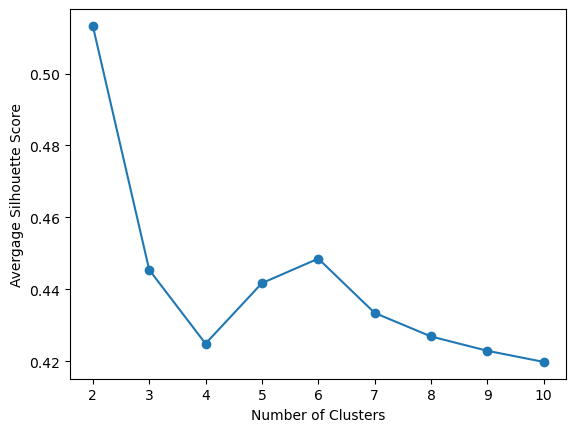

In [957]:
# Elbow Method ( Método do Cotovelo )
clusters = np.arange( 2, 11, 1 )
ss_list = []


for c in clusters:
    # define
    kmeans = ct.KMeans(n_clusters=c, init='random', n_init=10, random_state=0)

    # fit
    labels = kmeans.fit_predict(df3)

    # performance
    ss_avg = mt.silhouette_score(df3, labels)

    # add silhouette to list
    ss_list.append(ss_avg)


plt.plot(clusters, ss_list, marker='o')
plt.xlabel('Number of Clusters');
plt.ylabel('Avergage Silhouette Score');

# Agrupamentos
c = ss_list.index(max(ss_list)) + 2
print('Best K: {}'.format(c))

## 3.2 K-Means - Não Supervisionado

Cluster 0: 446 pontos
Cluster 1: 10 pontos
Cluster 2: 469 pontos
Cluster 3: 345 pontos
Cluster 4: 490 pontos
Cluster 5: 267 pontos


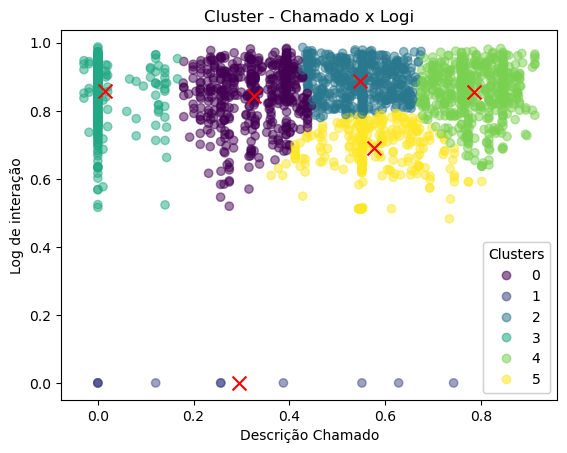

In [958]:
# Melhor valor de k em n_clusters
kmeans = ct.KMeans(n_clusters=6, init='random', n_init=10, random_state=0)
labels = kmeans.fit_predict(df3)

# Cluster counts
cluster_counts = np.bincount(labels)

# Quantidade de pontos do cluster
pontos_dict = {}
for cluster_num, count in enumerate(cluster_counts):

    pontos_dict[f'Cluster {cluster_num}'] = count
    
    print(f'Cluster {cluster_num}: {count} pontos')

# Coordenadas dos centroides
centroids = kmeans.cluster_centers_

# Plote os pontos
scatter = plt.scatter(df3.iloc[:, 0], df3.iloc[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")

# Plote os centroides
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)

plt.xlabel('Descrição Chamado')
plt.ylabel('Log de interação')
plt.title('Cluster - Chamado x Logi')
plt.gca().add_artist(legend1)

plt.show()

## 3.3 Rótulos dos clusters

In [959]:
# Rótulos dos clusters
df_labels = pd.DataFrame({'Cluster_Labels': labels})
df2_labeled = pd.concat([df2_to_label, df_labels], axis=1)

## 3.4 Verificando Grupos

In [960]:
# Suprimentos
cluster_0_data = df2_labeled[df2_labeled['Cluster_Labels'] == 0]
a = cluster_0_data.loc[:, ['descr_cham', 'logi']].groupby('descr_cham').count().sort_values('logi', ascending=False).reset_index()
a.head(10)

,descr_cham,logi
0,integracao,8
1,addon,7
2,compras,5
3,banksync,4
4,licencas proximas vencimento,4
5,encerramento exercicio,3
6,apuracao icms,2
7,criar usuario,2
8,imobilizado,2
9,servidor certificado,2


In [961]:
# Suporte
cluster_1_data = df2_labeled[df2_labeled['Cluster_Labels'] == 1]
b = cluster_1_data.loc[:, ['descr_cham', 'logi']].groupby('descr_cham').count().sort_values('logi', ascending=False).reset_index()
b.head(10)

,descr_cham,logi
0,chave,1
1,contas pagar docpay,1
2,derrubar acesso,1
3,docpay baixou parcialmente,1
4,inclusao permissao,1
5,layout,1
6,licenca banksyns,1
7,lista preco,1
8,reuniao integracao sap x unecont,1
9,ultima ativacao banksync,1


In [962]:
# Contabilidade
cluster_2_data = df2_labeled[df2_labeled['Cluster_Labels'] == 2]
c = cluster_2_data.loc[:, ['descr_cham', 'logi']].groupby('descr_cham').count().sort_values('logi', ascending=False).reset_index()
c.head(10)

,descr_cham,logi
0,instalacao sap,10
1,integracao,8
2,licenca hana,4
3,anexo aparece,4
4,fiscal,4
5,periodo contabil,3
6,ajuste impostos retidos fonte data,3
7,analise anexo,2
8,alcada anexo,2
9,ajuste calculo imposto,2


In [963]:
# Financeiro
cluster_3_data = df2_labeled[df2_labeled['Cluster_Labels'] == 3]
d = cluster_3_data.loc[:, ['descr_cham', 'logi']].groupby('descr_cham').count().sort_values('logi', ascending=False).reset_index()
d.head(10)

,descr_cham,logi
0,efdreinf,3
1,arvore consulta invalida,3
2,tabela preco,3
3,agendar anderson,2
4,instalacao,2
5,documentos abre,2
6,incluir gerente,2
7,ecf,2
8,depreciacao,2
9,bank sinc,2


In [964]:
# SAP Erros
cluster_4_data = df2_labeled[df2_labeled['Cluster_Labels'] == 4]
e = cluster_4_data.loc[:, ['descr_cham', 'logi']].groupby('descr_cham').count().sort_values('logi', ascending=False).reset_index()
e.head(10)

,descr_cham,logi
0,licenca sap,6
1,relatorio contas pagar,5
2,indisponibilidade acesso sap,5
3,sap ar,5
4,link download pl,4
5,acesso sap,4
6,sap funcionando,4
7,link download pl skill,3
8,fiscal nota,3
9,sap travado,3


In [965]:
# Licenças
cluster_5_data = df2_labeled[df2_labeled['Cluster_Labels'] == 5]
e = cluster_5_data.loc[:, ['descr_cham', 'logi']].groupby('descr_cham').count().sort_values('logi', ascending=False).reset_index()
e.head(10)

,descr_cham,logi
0,licenca banksync,10
1,licenca,10
2,fiscal,4
3,renovar licenca,4
4,atualizacao pl,4
5,licenca triple one,3
6,link pl,3
7,licenca hana,3
8,renovacao licenca,3
9,contrato saldo,2


# 4.0 Preparando o dataset para devolutiva

In [966]:
# Cocatenando dataframe original aos labels do cluster
df_grupos = pd.concat([df_raw, df_labels], axis=1)

# Renomeando coluna
df_grupos = df_grupos.rename(columns={'Cluster_Labels': 'GRUPO_CHAMADO'})

# Renomeando grupos
df_grupos['GRUPO_CHAMADO'] = df_grupos['GRUPO_CHAMADO'].astype(str)

mapeamento = {'0': 'Suprimentos',
              '1': 'Suporte',
              '2': 'Contabilidade',
              '3': 'Financeiro',
              '4': 'SAP Erros',
              '5': 'Licenças'}

df_grupos['GRUPO_CHAMADO'] = df_grupos['GRUPO_CHAMADO'].map(mapeamento)
df_grupos.head()

,TIPO_CHAMADO,DS_FRENTE_CHAMADO,DS_DESCRICAO_CHAMADO,LOG_INTERACAO,GRUPO_CHAMADO
0,INCIDENTE,B1,#0121-000006,Favor incluir o código ANP nas utilizações em ...,Contabilidade
1,INCIDENTE,B1,#0121-000009,Favor validar porque na carga é permitido e na...,Suprimentos
2,INCIDENTE,B1,PERIODO CONTABIL,Bom dia! Ao tentar fazer os lançamentos com a...,Contabilidade
3,INCIDENTE,B1,#0121-000015,"O relatório de Movimentações, em Granel Relató...",Licenças
4,INCIDENTE,B1,#0121-000022,Ao extrair o relatório de cliente das filiais ...,Suprimentos


## 4.1 Exportando Dataset

In [968]:
df_grupos.to_excel('dataset/grupos_chamados.xlsx', index=False)

# 5.0 Respondendo a pergunta

Grupos com mais chamados:

1- SAP Erros: 492 

2- Contabilidade: 464

3- Suprimentos: 448